# Pairs Trading with Machine Learning #

## Import Libraries ## 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.stattools import coint

from scipy import stats

from quantopian.pipeline.data import morningstar
from quantopian.pipeline.filters.morningstar import Q500US, Q1500US, Q3000US
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

## Acquire Stock Info ##

In [2]:
study_date = "2016-12-31"

universe = Q1500US()

pipe = Pipeline(
    columns= {
        'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),
        'Industry': morningstar.asset_classification.morningstar_industry_group_code.latest,
        'Financial Health': morningstar.asset_classification.financial_health_grade.latest
    },
    screen=universe
)

res = run_pipeline(pipe, study_date, study_date)
res.index = res.index.droplevel(0)  # drop the single date from the multi-index

print res.shape
# print res.head()

(1500, 3)


## Remove Undesired Stocks ##

In [3]:
# remove stocks in Industry "Conglomerates"
res = res[res['Industry']!=31055]
print res.shape

(1499, 3)


In [4]:
# remove stocks without a Financial Health grade
res = res[res['Financial Health']!= None]
print res.shape

(1498, 3)


In [5]:
# replace the categorical data with numerical scores per the docs
res['Financial Health'] = res['Financial Health'].astype('object')
health_dict = {u'A': 0.1,
               u'B': 0.3,
               u'C': 0.7,
               u'D': 0.9,
               u'F': 1.0}
res = res.replace({'Financial Health': health_dict})

In [6]:
# print res.head()

## Define Time Horizon ##

In [7]:
pricing = get_pricing(
    symbols=res.index,
    fields='close_price',
    start_date=pd.Timestamp("2016-12-31"),
    end_date=pd.Timestamp("2017-12-31")
)

In [8]:
pricing.shape

(251, 1498)

In [9]:
#change price to pct change
returns = pricing.pct_change()
# returns.head()

In [10]:
# returns[symbols(['AAPL'])].plot();

In [11]:
returns.shape

(251, 1498)

In [12]:
# we can only work with stocks that have the full return series
returns = returns.iloc[1:,:].dropna(axis=1)
print returns.shape
# print returns.head()

(250, 1419)


## Find Candidate Pairs ##
Given the pricing data and the fundamental and industry/sector data, we will first classify stocks into clusters and then, within clusters, looks for strong mean-reverting pair relationships.

Hypopthesis: "Stocks that share loadings to common factors in the past should be related in the future".

We first use Principle Component Analysis to reduce the dimensionality of the returns data and extract the historical latent common factor loadings for each stock.

We then use `DBSCAN` unsupervised learning, reasons:
- `DBSCAN` does not cluster *all* stocks; it leaves out stocks which do not neatly fit into a cluster;
- relatedly, you do not need to specify the number of clusters. 

The clustering algorithm will give us sensible *candidate* pairs. We will need to do some validation in the next step.

## Principle Component Analysis to Reduce Dimension ##

In [57]:
# RESTART from here!!!
X = returns.ix[:,].values.T
X.shape

(1419, 250)

### Standardize the Data ###

In [58]:
X_std = StandardScaler().fit_transform(X)

### Covariance Matrix ###
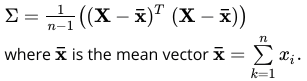

In [59]:
mean_vec = np.mean(X_std, axis=0)
cov_mat = (X_std - mean_vec).T.dot(X_std - mean_vec) / (X_std.shape[0]-1)
# print('Covariance matrix \n%s' %cov_mat)
cov_mat.shape

(250, 250)

In [60]:
# Next, we perform an eigendecomposition on the covariance matrix
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors', eig_vecs.shape)
print('Eigenvalues', eig_vals.shape)

('Eigenvectors', (250, 250))
('Eigenvalues', (250,))


###  Select Principal Components ###

In [61]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
# print('Eigenvalues in descending order:')
# for i in eig_pairs:
#     print(i[0])

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [62]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

we want to select features that stand for 90% of the variance

In [63]:
cum_var_exp = cum_var_exp[cum_var_exp[:] < 50]

valid_cols = cum_var_exp.shape[0]
orig_cols = len(eig_vals)

print("orig_cols", orig_cols)
print("valid_cols", valid_cols)

('orig_cols', 250)
('valid_cols', 45)


Here, we are reducing the 250-dimensional feature space to a 167-dimensional feature subspace, by choosing the "top 167" eigenvectors with the highest eigenvalues to construct our d×k-dimensional eigenvector matrix W.

In [64]:
# init matrix_w
matrix_w = np.hstack(eig_pairs[0][1]).reshape(orig_cols,1)

# concatenate matrix_w
for i in range(valid_cols-1):
    temp_vec = np.hstack(eig_pairs[i+1][1]).reshape(orig_cols,1)
    matrix_w = np.hstack((matrix_w,temp_vec))

### Projection Onto the New Feature Space ###

X: original matrix<br>
X_std: standardized matrix<br>
X_PCA: matrix after PCA dimension reduction<br>
X_TO_CLST: matrix ready to be clustered

In [65]:
X_PCA = X_std.dot(matrix_w)

print("shape of new features matrix: ", X_PCA.shape)

('shape of new features matrix: ', (1419, 45))


We have done the PCA to reduce dimension. Let's add some fundamental values as well to make the model more robust.

In [66]:
X_AFT_PCA = np.hstack(
    (X_PCA,
     res['Market Cap'][returns.columns].values[:, np.newaxis],
     res['Financial Health'][returns.columns].values[:, np.newaxis])
    )

print X_AFT_PCA.shape

(1419, 47)


## DBSCAN Clustering to Find Pairs ##

### Find Optimal Epsilon for DBSCAN ###
We will maily adopt the ideas mentioned in this [paper](http://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf). 
The method proposed here consists of computing the he k-nearest neighbor distances in a matrix of points.

The idea is to calculate, the average of the distances of every point to its k nearest neighbors. The value of k will be specified by the user and corresponds to MinPts.

Next, these k-distances are plotted in an ascending order. The aim is to determine the “knee”, which corresponds to the optimal eps parameter.

A knee corresponds to a threshold where a sharp change occurs along the k-distance curve.

The DBSCAN paper suggests to choose minPts based on the dimensionality, and eps based on the elbow in the k-distance graph.

In [67]:
from sklearn.neighbors import NearestNeighbors

# norm_data = MinMaxScaler()
# X1 = norm_data.fit_transform(Y)

X_TO_CLST = preprocessing.StandardScaler().fit_transform(X_AFT_PCA)

nbrs = NearestNeighbors(n_neighbors=10).fit(X_TO_CLST)
distances, indices = nbrs.kneighbors(X_TO_CLST)

# sort and plot the distance
# distances = np.sort(distances, axis=0)

# print(distances)

# plt.plot(distances)

# distances.shape
# distances = distances[:,:-1,:] # trim first column

[  0.89788106   0.97072249   0.97996104 ...,  22.07900858  22.99585615
  24.70435204]


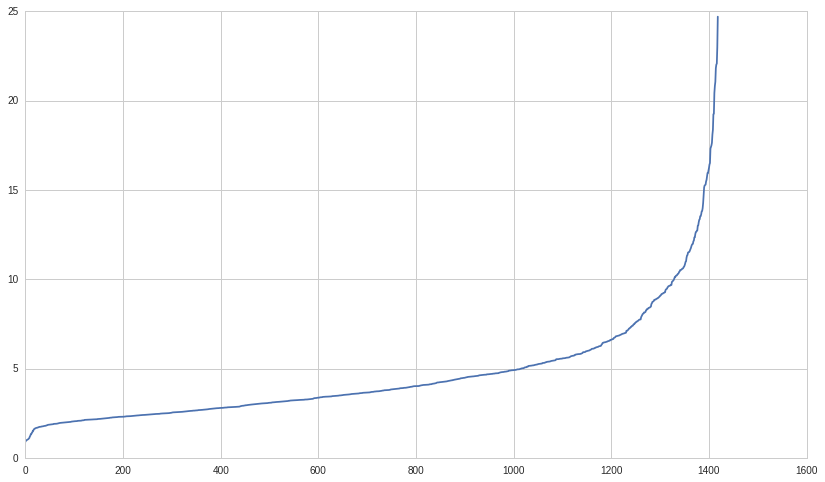

In [68]:
distances = distances.mean(axis=1)
distances = np.sort(distances, axis=0)
print(distances)
plt.plot(distances)

In [80]:
clf = DBSCAN(eps=5, min_samples=2)
print clf

DBSCAN(algorithm='auto', eps=5, leaf_size=30, metric='euclidean',
    min_samples=2, p=None, random_state=None)


In [70]:
clf.fit(X_TO_CLST)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print "\nClusters discovered: %d" % n_clusters_

clustered = clf.labels_


Clusters discovered: 2


In [71]:
# the initial dimensionality of the search was
ticker_count = len(returns.columns)
print "Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2)

Total pairs possible in universe: 1006071 


In [72]:
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [73]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print "Clusters formed: %d" % len(ticker_count_reduced)
print "Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum()

Clusters formed: 2
Pairs to evaluate: 961410


In [74]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X_TO_CLST)

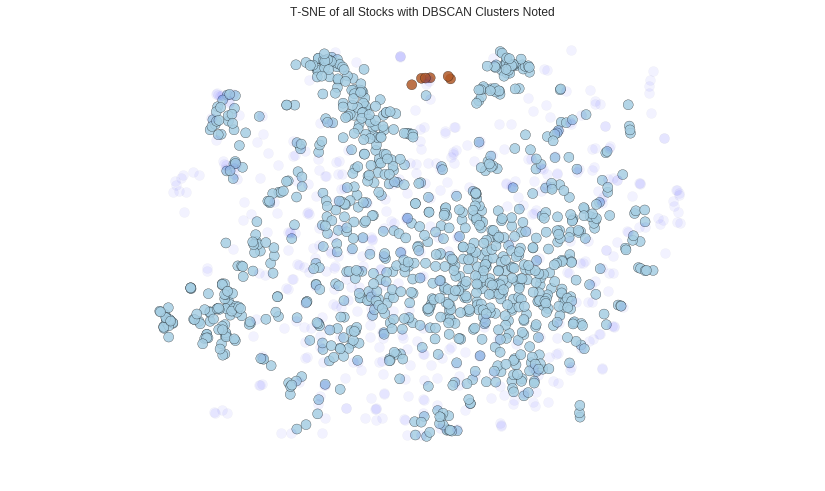

In [75]:
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted');

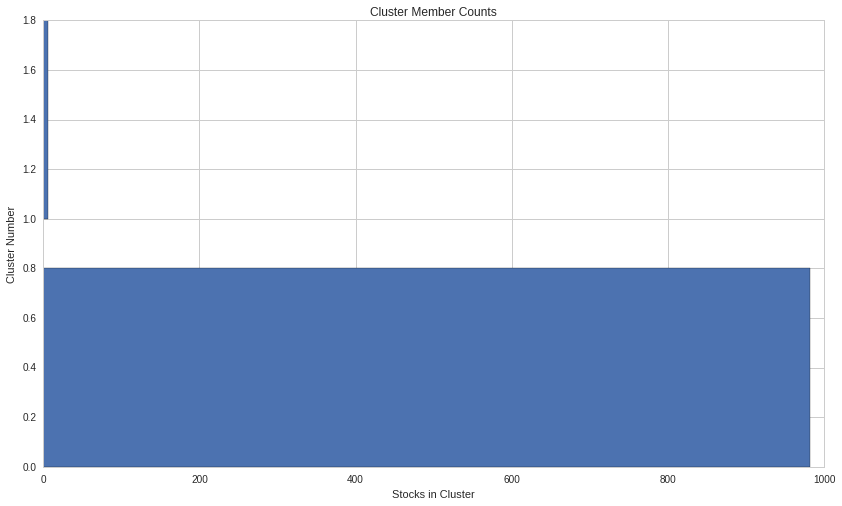

In [76]:
plt.barh(
    xrange(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

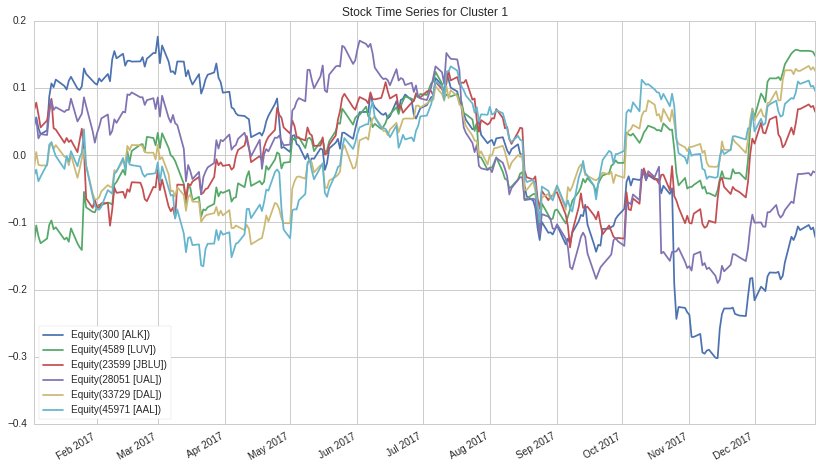

In [77]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 3)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(pricing[tickers].mean())
    data = np.log(pricing[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)

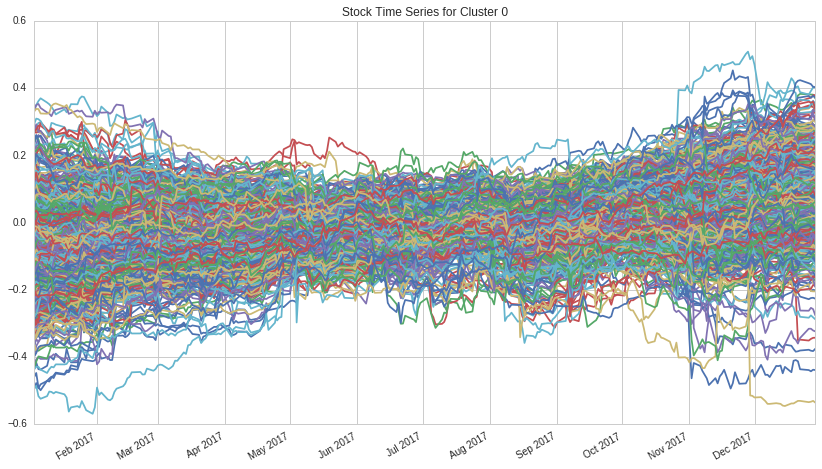

In [78]:
which_cluster = clustered_series.loc[symbols('JPM')]
clustered_series[clustered_series == which_cluster]

tickers = list(clustered_series[clustered_series==which_cluster].index)
means = np.log(pricing[tickers].mean())
data = np.log(pricing[tickers]).sub(means)
data.plot(legend=False, title="Stock Time Series for Cluster %d" % which_cluster);